In [1]:
%precision 3
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sl
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from matplotlib import cm
import matplotlib.animation as animation
from IPython.display import HTML
from pprint import pprint

# Part A

In [30]:
def pressure_poisson_jacobi(p, dx, dy, RHS, rtol = 1.e-5, logs = False):
    """ Solve the pressure Poisson equation (PPE)
    using Jacobi iteration assuming mesh spacing of
    dx and dy (we assume at the moment that dx=dy)
    and the RHS function given by RHS.
    
    Assumes imposition of a Neumann BC on all boundaries.
    
    Return the pressure field.
    """
    # iterate
    tol = 10.*rtol
    it = 0
    p_old = np.copy(p)
    
    imax = len(p)
    jmax = np.size(p)//imax
    
    while tol > rtol:
        it += 1
        
        #swap arrays without copying the data
        temp = p_old
        p_old = p
        p = temp
        
        #this version is valid for dx!=dy
        p[1:-1, 1:-1] = 1.0/(2.0+2.0*(dx**2)/(dy**2))*(p_old[2:, 1:-1] + p_old[:-2, 1:-1] +
                                (p_old[1:-1, 2:] + p_old[1:-1,:-2])*(dx**2)/(dy**2)
                                - (dx**2)*RHS[1:-1, 1:-1])
        
        # apply zero gradient Neumann boundary conditions at the no slip walls
        p[1:-1, 0] = p[1:-1, 1] # bottom wall
        p[:(imax//2), -1] = p[:(imax//2), -2] # top wall # potential mistake
        p[-1, 1:-1] = p[-2, 1:-1] # right wall

        # relative change in pressure
        tol = sl.norm(p - p_old)/np.maximum(1.0e-10,sl.norm(p))
        
    if logs: print('pressure solve iterations = {:4d}'.format(it))
    return p

In [31]:
def calculate_ppm_RHS_upwind(rho, u, v, RHS, dt, dx, dy):
    """ Calculate the RHS of the 
    Poisson equation resulting from the projection method.
    Use upwind differences for the first derivatives of u and v.
    """
    RHS[1:-1, 1:-1] =rho*(np.select([u[1:-1, 1:-1] > 0, u[1:-1, 1:-1] <= 0],
                      [np.diff(u[:-1, 1:-1], n=1, axis=0)/dx,
                       np.diff(u[1:, 1:-1], n=1, axis=0)/dx]) + 
              np.select([v[1:-1, 1:-1] > 0, v[1:-1, 1:-1] <= 0],
                      [np.diff(v[1:-1, :-1], n=1, axis=1)/dy,
                       np.diff(v[1:-1, 1:], n=1, axis=1)/dy]))
    return RHS

def calculate_ppm_RHS_central(rho, u, v, RHS, dt, dx, dy):
    """ Calculate the RHS of the 
    Poisson equation resulting from the projection method.
    Use central differences for the first derivatives of u and v.
    """
    RHS[1:-1, 1:-1] = rho * (
        (1.0/dt) * ( (u[2:, 1:-1] - u[:-2, 1:-1]) / (2.0*dx) 
                   + (v[1:-1, 2:] - v[1:-1, :-2]) / (2.0*dy) ))
    return RHS

def project_velocity(rho, u, v, dt, dx, dy, p):
    """ Update the velocity to be divergence free using the pressure.
    """
    u[1:-1, 1:-1] = u[1:-1, 1:-1] - dt * (1./rho) * (
        (p[2:, 1:-1] - p[:-2, 1:-1])/(2*dx) )
    v[1:-1, 1:-1] = v[1:-1, 1:-1] - dt * (1./rho) * (
        (p[1:-1, 2:] - p[1:-1, :-2])/(2*dy) )
    
    #apply the velocity boundary condition to the projected velocity data
    #apply the velocity boundary condition
    imax = len(u)
    jmax = np.size(u)//imax
    
    
    u[0, :] = u[1, :]
    v[imax//2:,-1] = v[imax//2:,-2] # top wall, right half

    return u, v

def calculate_intermediate_velocity(nu, u, v, u_old, v_old, dt, dx, dy):
    """ Calculate the intermediate velocities.
    """
    # intermediate u
    u[1:-1, 1:-1] = u_old[1:-1, 1:-1] - dt * (
                      # ADVECTION:  uu_x + vu_x
                        u_old[1:-1, 1:-1] *
                      # see comments in the upwind based solver for advection above
                      np.select([u_old[1:-1, 1:-1] > 0, u_old[1:-1, 1:-1] < 0],
                      [np.diff(u_old[:-1, 1:-1], n=1, axis=0)/dx,
                       np.diff(u_old[1:, 1:-1], n=1, axis=0)/dx]) +
                             v_old[1:-1, 1:-1] *
                       np.select([v_old[1:-1, 1:-1] > 0, v_old[1:-1, 1:-1] < 0],
                      [np.diff(u_old[1:-1, :-1], n=1, axis=1)/dy,
                       np.diff(u_old[1:-1, 1:], n=1, axis=1)/dy]) ) + (
                       # DIFFUSION
                         dt*nu*(np.diff(u_old[:, 1:-1], n=2, axis=0)/(dx**2)
                                 + np.diff(u_old[1:-1, :], n=2, axis=1)/(dy**2)) )
    # intermediate v
    v[1:-1, 1:-1] = v_old[1:-1, 1:-1] - dt * (
                      # ADVECTION:  uv_x + vv_x
                        u_old[1:-1, 1:-1] *
                      np.select([u_old[1:-1, 1:-1] > 0, u_old[1:-1, 1:-1] < 0],
                      [np.diff(v_old[:-1, 1:-1], n=1, axis=0)/dx,
                       np.diff(v_old[1:, 1:-1], n=1, axis=0)/dx]) +
                             v_old[1:-1, 1:-1] *
                       np.select([v_old[1:-1, 1:-1] > 0, v_old[1:-1, 1:-1] < 0],
                      [np.diff(v_old[1:-1, :-1], n=1, axis=1)/dy,
                       np.diff(v_old[1:-1, 1:], n=1, axis=1)/dy]) ) + (
                       # DIFFUSION
                        dt*nu*(np.diff(v_old[:, 1:-1], n=2, axis=0)/(dx**2)
                                 + np.diff(v_old[1:-1, :], n=2, axis=1)/(dy**2)) )
    
    return u, v

In [32]:
def solve_NS(u, v, p, rho, nu, courant, dt_min, t_end, dx, dy, rtol = 1.e-5, logs = False, outint = 100):
    """ Solve the incompressible Navier-Stokes equations
    using a lot of the numerical choices and approaches we've seen
    earlier in this lecture.
    """
    t = 0
    
    u_old = u.copy()
    v_old = v.copy()
    p_RHS = np.zeros_like(X)
    
    time_it = 0 
    
    while t < t_end:
        time_it+=1
        #set dt based on courant number
        vel_max = np.max(np.sqrt(u**2+v**2))
        if vel_max>0.0:
            dt = min(courant*min(dx,dy)/vel_max,dt_min)
        else:
            dt = dt_min
            
        t += dt
        if logs and time_it%outint == 0: 
            print('\nTime = {:.8f}'.format(t))
            
        # calculate intermediate velocities
        u, v = calculate_intermediate_velocity(nu, u, v, u_old, v_old, dt, dx, dy)
        # PPM
        # calculate RHS for the pressure Poisson problem
        p_RHS = calculate_ppm_RHS_central(rho, u, v, p_RHS, dt, dx, dy)
        # compute pressure - note that we use the previous p as an initial guess to the solution
        p = pressure_poisson_jacobi(p, dx, dy, p_RHS, 1.e-5, logs = (logs and time_it%outint == 0))
        # project velocity
        u, v = project_velocity(rho, u, v, dt, dx, dy, p)
        
        if logs and time_it%outint == 0:
            print('norm(u) = {0:.8f}, norm(v) = {1:.8f}'.format(sl.norm(u),sl.norm(v)))
            print('Courant number: {0:.8f}'.format(np.max(np.sqrt(u**2+v**2)) * dt / min(dx,dy)))
                
        #swap pointers without copying data
        temp = u_old
        u_old = u
        u = temp
        temp = v_old
        v_old = v
        v = temp
    return u, v, p

In [62]:
# physical parameters
rho = 1000
mu = 0.001
nu = mu/ rho

# define spatial mesh
# Size of rectangular domain
Lx = .01
Ly = Lx/2

P_max = 0.5

# Number of grid points in each direction, including boundary nodes
Nx = 101
Ny = 51

# hence the mesh spacing
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)

# read the docs to see the ordering that mgrid gives us
X, Y = np.mgrid[0:Nx:1, 0:Ny:1]
X = dx*X
Y = dy*Y
# the following is an alternative to the three lines above
#X, Y = np.mgrid[0: Lx + 1e-10: dx, 0: Ly + 1e-10: dy]
# but without the need to add a "small" increement to ensure
# the Lx and Ly end points are included

# initialise independent variables
u = np.zeros_like(X)
v = np.zeros_like(X)
p = np.zeros_like(X)

# Apply Dirichlet BCs to u and v - the code below doesn't touch 
# these so we can do this once outside the time loop
u[:, -1] = 0
u[:, 0] = 0
u[0, :] = 0
u[-1, :] = 0
v[:, -1] = 0
v[:, 0] = 0
v[0, :] = 0
v[-1, :] = 0
imax = len(p)
jmax = np.size(p)//imax

# left boundary
p[0, :] = P_max
p[imax//2:, -1] = 0.0

#set a Courant number and use dynamic time step
courant = 0.01
dt_min = 1.e-3

t_end = 10.

import time
start = time.time()
u, v, p = solve_NS(u, v, p, rho, nu, courant, dt_min, t_end, dx, dy, rtol=1.e-6, logs = True, outint = 10000)
end = time.time()
print('Time taken by calculation = ', end - start)


Time = 0.12930683
pressure solve iterations =    9
norm(u) = 0.41674453, norm(v) = 0.20057214
Courant number: 0.01000729

Time = 0.19776099
pressure solve iterations =    9
norm(u) = 0.61293174, norm(v) = 0.28921649
Courant number: 0.01000391

Time = 0.25363094
pressure solve iterations =    9
norm(u) = 0.76183184, norm(v) = 0.35533446
Courant number: 0.01000260

Time = 0.30262152
pressure solve iterations =    7
norm(u) = 0.88281443, norm(v) = 0.40847047
Courant number: 0.01000192

Time = 0.34709587
pressure solve iterations =    6
norm(u) = 0.98387294, norm(v) = 0.45223317
Courant number: 0.01000155

Time = 0.38824665
pressure solve iterations =    7
norm(u) = 1.06939372, norm(v) = 0.48853628
Courant number: 0.01000128

Time = 0.42683944
pressure solve iterations =    6
norm(u) = 1.14242093, norm(v) = 0.51875117
Courant number: 0.01000108

Time = 0.46339599
pressure solve iterations =    5
norm(u) = 1.20518174, norm(v) = 0.54394328
Courant number: 0.01000093

Time = 0.49828416
press


Time = 2.00467277
pressure solve iterations =    1
norm(u) = 1.61351298, norm(v) = 0.61964512
Courant number: 0.01000000

Time = 2.02820581
pressure solve iterations =    1
norm(u) = 1.61312732, norm(v) = 0.61919365
Courant number: 0.01000000

Time = 2.05173652
pressure solve iterations =    1
norm(u) = 1.61275001, norm(v) = 0.61876303
Courant number: 0.01000000

Time = 2.07526519
pressure solve iterations =    1
norm(u) = 1.61238140, norm(v) = 0.61835251
Courant number: 0.01000000

Time = 2.09879211
pressure solve iterations =    1
norm(u) = 1.61202182, norm(v) = 0.61796138
Courant number: 0.01000000

Time = 2.12231752
pressure solve iterations =    1
norm(u) = 1.61167149, norm(v) = 0.61758891
Courant number: 0.01000000

Time = 2.14584165
pressure solve iterations =    1
norm(u) = 1.61133060, norm(v) = 0.61723441
Courant number: 0.01000000

Time = 2.16936470
pressure solve iterations =    1
norm(u) = 1.61099929, norm(v) = 0.61689718
Courant number: 0.01000000

Time = 2.19288687
press


Time = 3.60477314
pressure solve iterations =    1
norm(u) = 1.60368744, norm(v) = 0.61134804
Courant number: 0.01000000

Time = 3.62831672
pressure solve iterations =    1
norm(u) = 1.60367260, norm(v) = 0.61134377
Courant number: 0.01000000

Time = 3.65186049
pressure solve iterations =    1
norm(u) = 1.60365875, norm(v) = 0.61133996
Courant number: 0.01000000

Time = 3.67540445
pressure solve iterations =    1
norm(u) = 1.60364582, norm(v) = 0.61133658
Courant number: 0.01000000

Time = 3.69894858
pressure solve iterations =    1
norm(u) = 1.60363377, norm(v) = 0.61133358
Courant number: 0.01000000

Time = 3.72249288
pressure solve iterations =    1
norm(u) = 1.60362253, norm(v) = 0.61133095
Courant number: 0.01000000

Time = 3.74603734
pressure solve iterations =    1
norm(u) = 1.60361207, norm(v) = 0.61132864
Courant number: 0.01000000

Time = 3.76958195
pressure solve iterations =    1
norm(u) = 1.60360234, norm(v) = 0.61132664
Courant number: 0.01000000

Time = 3.79312671
press


Time = 5.20591974
pressure solve iterations =    1
norm(u) = 1.60349922, norm(v) = 0.61134365
Courant number: 0.01000000

Time = 5.22946684
pressure solve iterations =    1
norm(u) = 1.60349942, norm(v) = 0.61134391
Courant number: 0.01000000

Time = 5.25301393
pressure solve iterations =    1
norm(u) = 1.60349961, norm(v) = 0.61134415
Courant number: 0.01000000

Time = 5.27656103
pressure solve iterations =    1
norm(u) = 1.60349981, norm(v) = 0.61134438
Courant number: 0.01000000

Time = 5.30010812
pressure solve iterations =    1
norm(u) = 1.60350000, norm(v) = 0.61134461
Courant number: 0.01000000

Time = 5.32365522
pressure solve iterations =    1
norm(u) = 1.60350018, norm(v) = 0.61134482
Courant number: 0.01000000

Time = 5.34720232
pressure solve iterations =    1
norm(u) = 1.60350037, norm(v) = 0.61134502
Courant number: 0.01000000

Time = 5.37074942
pressure solve iterations =    1
norm(u) = 1.60350054, norm(v) = 0.61134521
Courant number: 0.01000000

Time = 5.39429652
press


Time = 6.80712237
pressure solve iterations =    1
norm(u) = 1.60350465, norm(v) = 0.61134844
Courant number: 0.01000000

Time = 6.83066947
pressure solve iterations =    1
norm(u) = 1.60350466, norm(v) = 0.61134844
Courant number: 0.01000000

Time = 6.85421656
pressure solve iterations =    1
norm(u) = 1.60350466, norm(v) = 0.61134845
Courant number: 0.01000000

Time = 6.87776365
pressure solve iterations =    1
norm(u) = 1.60350467, norm(v) = 0.61134845
Courant number: 0.01000000

Time = 6.90131074
pressure solve iterations =    1
norm(u) = 1.60350468, norm(v) = 0.61134845
Courant number: 0.01000000

Time = 6.92485783
pressure solve iterations =    1
norm(u) = 1.60350469, norm(v) = 0.61134845
Courant number: 0.01000000

Time = 6.94840492
pressure solve iterations =    1
norm(u) = 1.60350469, norm(v) = 0.61134845
Courant number: 0.01000000

Time = 6.97195201
pressure solve iterations =    1
norm(u) = 1.60350470, norm(v) = 0.61134845
Courant number: 0.01000000

Time = 6.99549910
press


Time = 8.40832446
pressure solve iterations =    1
norm(u) = 1.60350476, norm(v) = 0.61134845
Courant number: 0.01000000

Time = 8.43187155
pressure solve iterations =    1
norm(u) = 1.60350476, norm(v) = 0.61134845
Courant number: 0.01000000

Time = 8.45541864
pressure solve iterations =    1
norm(u) = 1.60350476, norm(v) = 0.61134845
Courant number: 0.01000000

Time = 8.47896573
pressure solve iterations =    1
norm(u) = 1.60350476, norm(v) = 0.61134845
Courant number: 0.01000000

Time = 8.50251282
pressure solve iterations =    1
norm(u) = 1.60350476, norm(v) = 0.61134845
Courant number: 0.01000000

Time = 8.52605991
pressure solve iterations =    1
norm(u) = 1.60350476, norm(v) = 0.61134845
Courant number: 0.01000000

Time = 8.54960699
pressure solve iterations =    1
norm(u) = 1.60350476, norm(v) = 0.61134845
Courant number: 0.01000000

Time = 8.57315408
pressure solve iterations =    1
norm(u) = 1.60350476, norm(v) = 0.61134845
Courant number: 0.01000000

Time = 8.59670117
press

Time taken by calculation =  314.379337310791


Text(0.5, 1.0, 'Pressure driven problem - speed at t = 10s')

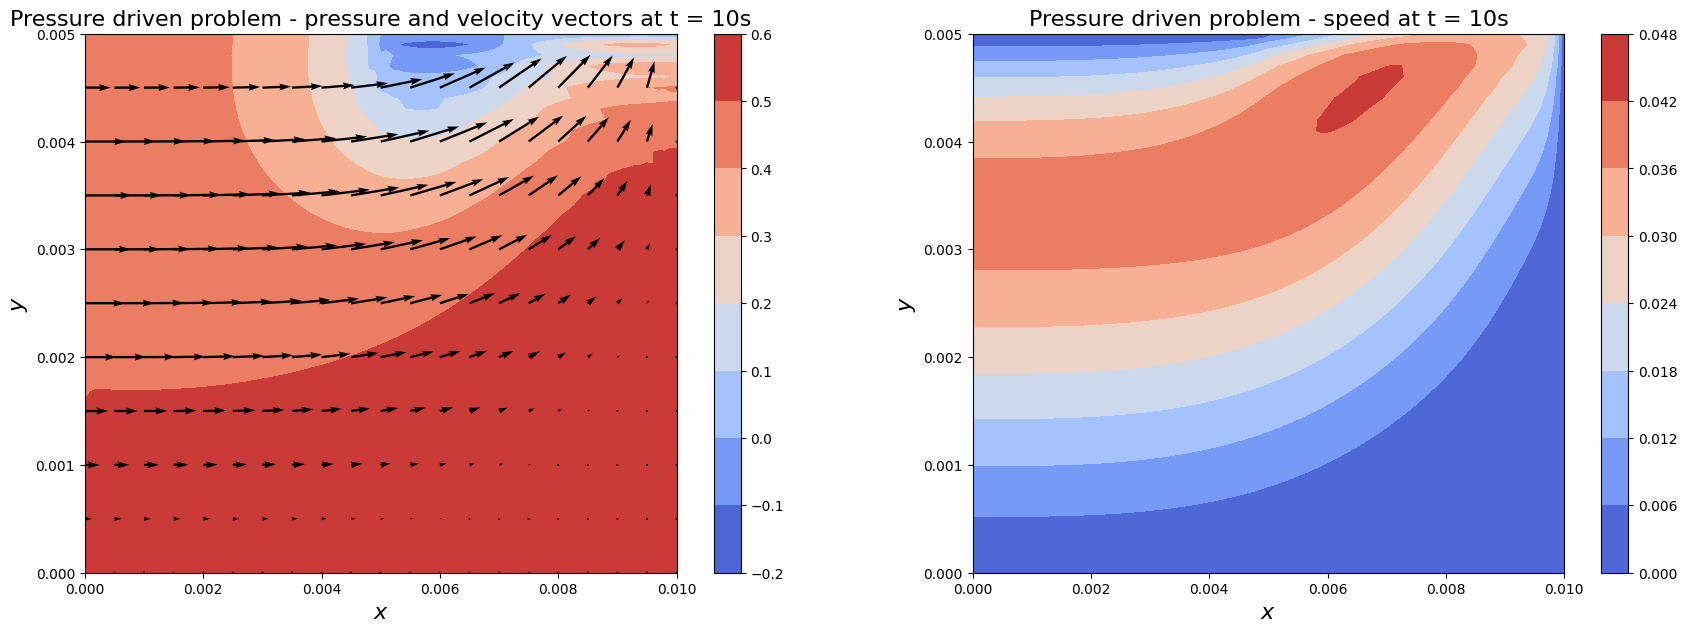

In [64]:
# set up figure
fig = plt.figure(figsize=(21, 7))
ax1 = fig.add_subplot(121)
cont = ax1.contourf(X,Y,p, cmap=cm.coolwarm)
fig.colorbar(cont)
# don't plot at every gird point - every 5th
ax1.quiver(X[::5,::5],Y[::5,::5],u[::5,::5],v[::5,::5])
ax1.set_xlim(-0.0000001, Lx + 0.0000001)
ax1.set_ylim(-0.0000001, Ly + 0.0000001)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Pressure driven problem - pressure and velocity vectors at t = 10s', fontsize=16)

ax1 = fig.add_subplot(122)
cont = ax1.contourf(X,Y,np.sqrt(u*u+v*v), cmap=cm.coolwarm)
fig.colorbar(cont)
ax1.set_xlim(-0.0000001, Lx + 0.0000001)
ax1.set_ylim(-0.0000001, Ly + 0.0000001)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Pressure driven problem - speed at t = 10s', fontsize=16)

In [65]:
flow_in = np.sum(u[0,:])*Ly
flow_out = np.sum(v[:,-1])*Ly

print('flow in ',flow_in)
print('flow out ',flow_out)

flow in  0.005730771547102114
flow out  0.005687667556554739


In [68]:
average_flow = np.average(u[0,:])
average_flow

0.022

Calculating the Reynolds number based onn the average velocity. I'm using Ly as length scale - this is since for this case both inlet and outlet are the same size 

In [75]:
Re = np.average(np.sqrt(u**2+v**2))*Ly/nu
Re

96.548

# Part B

If it doesn't render check directory for Q2_part_b.pdf

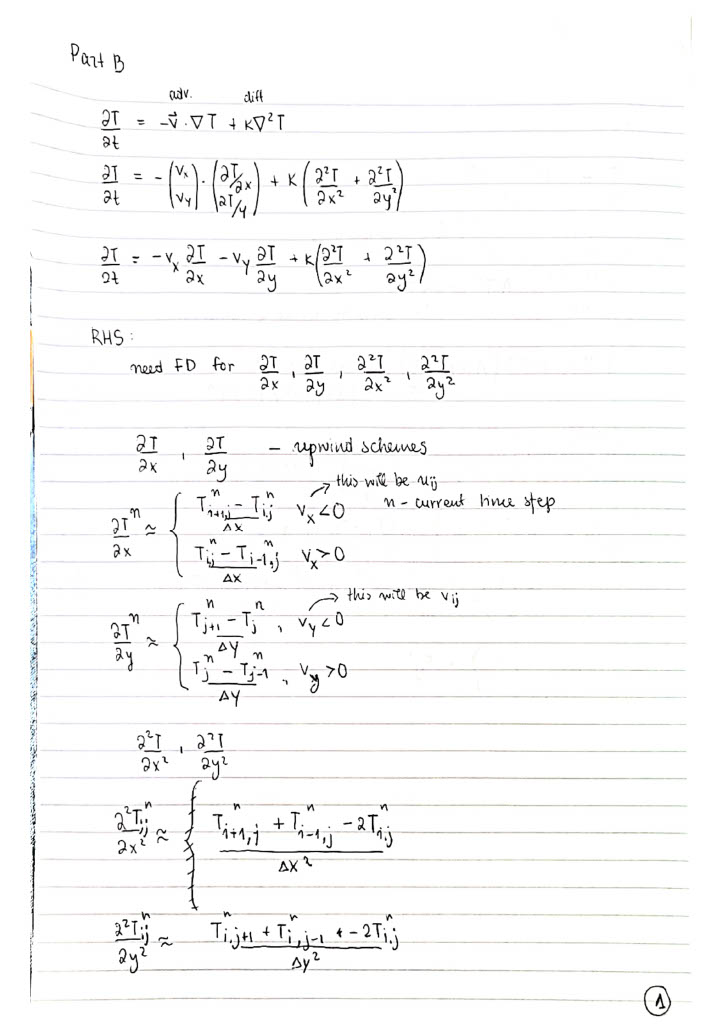

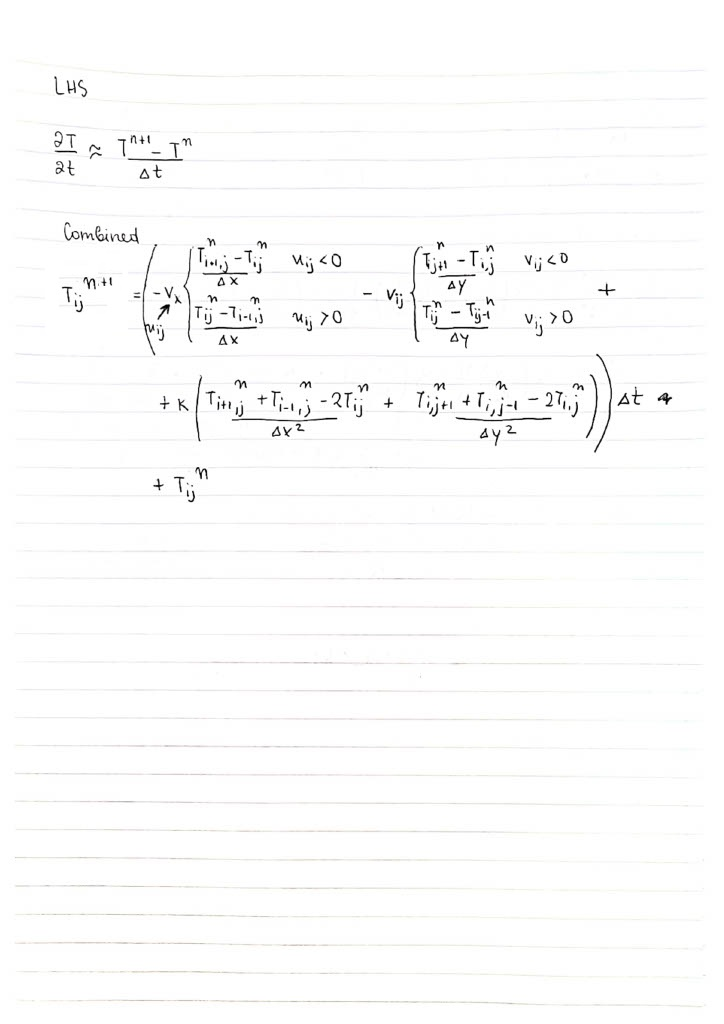

# Part C - Temperature

In [168]:
def calculate_new_T(T, u, v, dx, dy, dt, k):
    T_new = np.copy(T)
    
    T_new[1:-1, 1:-1] = - u[1:-1, 1:-1] * (np.select([u[1:-1, 1:-1] > 0, u[1:-1, 1:-1] <= 0],
                      [np.diff(T[:-1, 1:-1], n=1, axis=0)/dx,
                       np.diff(T[1:, 1:-1], n=1, axis=0)/dx])) - \
            + v[1:-1, 1:-1] * (np.select([v[1:-1, 1:-1] > 0, v[1:-1, 1:-1] <= 0],
                       [np.diff(T[:-1, 1:-1], n=1, axis=0)/dx,
                       np.diff(T[1:, 1:-1], n=1, axis=0)/dx])) + \
            + k * (T[2:, 1:-1] + T[:-2, 1:-1] - 2 * T[1:-1, 1:-1])/(dx**2) + \
            + k *(T[1:-1, 2:] + T[1:-1, :-2] - 2 * T[1:-1, 1:-1])/(dy**2)
    T_new[1:-1, 1:-1] = dt * T_new[1:-1, 1:-1] + T[1:-1, 1:-1]
    
    T_new[imax//2:, -1] = T_new[imax//2:, -2]
    
    return T_new

In [238]:
def solve_NS_with_T(T, k, u, v, p, rho, nu, courant, dt_min, t_end, dx, dy, rtol = 1.e-5, logs = False, outint = 100):
    """ Solve the incompressible Navier-Stokes equations
    using a lot of the numerical choices and approaches we've seen
    earlier in this lecture.
    """
    t = 0
    
    u_old = u.copy()
    v_old = v.copy()
    p_RHS = np.zeros_like(X)
    
    time_it = 0 
    
    while t < t_end:
        time_it+=1
        #set dt based on courant number
        vel_max = np.max(np.sqrt(u**2+v**2))
        if vel_max>0.0:
            # check for fluid condition and heat condition for the time step
            dt = min(courant*min(dx,dy)/vel_max,dt_min, 0.2*(min(dx,dy)**2)/(2*k))
        else:
            dt = dt_min
            
        t += dt
        if logs and time_it%outint == 0: 
            print('\nTime = {:.8f}'.format(t))
            
        # calculate intermediate velocities
        u, v = calculate_intermediate_velocity(nu, u, v, u_old, v_old, dt, dx, dy)
        # PPM
        # calculate RHS for the pressure Poisson problem
        p_RHS = calculate_ppm_RHS_central(rho, u, v, p_RHS, dt, dx, dy)
        # compute pressure - note that we use the previous p as an initial guess to the solution
        p = pressure_poisson_jacobi(p, dx, dy, p_RHS, 1.e-5, logs = (logs and time_it%outint == 0))
        # project velocity
        u, v = project_velocity(rho, u, v, dt, dx, dy, p)
        
        T = calculate_new_T(T, u, v, dx, dy, dt, k)
        
        if logs and time_it%outint == 0:
            print('norm(u) = {0:.8f}, norm(v) = {1:.8f}'.format(sl.norm(u),sl.norm(v)))
            print('Courant number: {0:.8f}'.format(np.max(np.sqrt(u**2+v**2)) * dt / min(dx,dy)))
            print('norm(T) = {0:.8f}'.format(sl.norm(T)))
            print('dt = {0:.8f}'.format(dt))
                
        #swap pointers without copying data
        temp = u_old
        u_old = u
        u = temp
        temp = v_old
        v_old = v
        v = temp
    return u, v, p, T

In [173]:
# physical parameters
rho = 1000
nu = 0.001/ rho
k = 5e-6

# define spatial mesh
# Size of rectangular domain
Lx = .01
Ly = Lx/2

P_max = 0.5

# Number of grid points in each direction, including boundary nodes
Nx = 101
Ny = 51

# hence the mesh spacing
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)

# read the docs to see the ordering that mgrid gives us
X, Y = np.mgrid[0:Nx:1, 0:Ny:1]
X = dx*X
Y = dy*Y
# the following is an alternative to the three lines above
#X, Y = np.mgrid[0: Lx + 1e-10: dx, 0: Ly + 1e-10: dy]
# but without the need to add a "small" increement to ensure
# the Lx and Ly end points are included

# initialise independent variables
u = np.zeros_like(X)
v = np.zeros_like(X)
p = np.zeros_like(X)

# Apply Dirichlet BCs to u and v - the code below doesn't touch 
# these so we can do this once outside the time loop
u[:, -1] = 0
u[:, 0] = 0
u[0, :] = 0
u[-1, :] = 0
v[:, -1] = 0
v[:, 0] = 0
v[0, :] = 0
v[-1, :] = 0
imax = len(p)
jmax = np.size(p)//imax

# left boundary
p[0, :] = P_max
p[imax//2:, -1] = 0.0

#set a Courant number and use dynamic time step
courant = 0.005
dt_min = 1.e-3

t_end = 10.

T = np.zeros_like(X)

# Dirichlet BCs
T[0, :] = 20 # left
T[-1,:] = 100 # right 
T[:, 0] = 100 # bottom
T[:imax//2, -1] = 100 # top

import time
start = time.time()
u, v, p, T = solve_NS_with_T(T, k, u, v, p, rho, nu, courant, dt_min, t_end, dx, dy, rtol=1.e-6, logs = True, outint = 10000)
end = time.time()
print('Time taken by calculation = ', end - start)


Time = 0.34857541
pressure solve iterations =    3
norm(u) = 0.98164954, norm(v) = 0.45100611
Courant number: 0.00500039
norm(T) = 4205.70880330
dt = 0.00002136

Time = 0.53339759
pressure solve iterations =    2
norm(u) = 1.29989133, norm(v) = 0.57915599
Courant number: 0.00500018
norm(T) = 4438.84816990
dt = 0.00001645

Time = 0.68626043
pressure solve iterations =    1
norm(u) = 1.45613771, norm(v) = 0.63091684
Courant number: 0.00500010
norm(T) = 4356.08486306
dt = 0.00001436

Time = 0.82399841
pressure solve iterations =    1
norm(u) = 1.53633872, norm(v) = 0.65004820
Courant number: 0.00500006
norm(T) = 4307.18806517
dt = 0.00001330

Time = 0.95372804
pressure solve iterations =    1
norm(u) = 1.57795842, norm(v) = 0.65423661
Courant number: 0.00500004
norm(T) = 4294.81319198
dt = 0.00001270

Time = 1.07887795
pressure solve iterations =    1
norm(u) = 1.59910252, norm(v) = 0.65162556
Courant number: 0.00500002
norm(T) = 4297.98346497
dt = 0.00001235

Time = 1.20125544
pressure 


Time = 6.49737850
pressure solve iterations =    1
norm(u) = 1.59401335, norm(v) = 0.60654483
Courant number: 0.00500000
norm(T) = 4375.56716305
dt = 0.00001175

Time = 6.61491801
pressure solve iterations =    1
norm(u) = 1.59401344, norm(v) = 0.60654487
Courant number: 0.00500000
norm(T) = 4375.56712579
dt = 0.00001175

Time = 6.73245751
pressure solve iterations =    1
norm(u) = 1.59401351, norm(v) = 0.60654489
Courant number: 0.00500000
norm(T) = 4375.56710775
dt = 0.00001175

Time = 6.84999700
pressure solve iterations =    1
norm(u) = 1.59401357, norm(v) = 0.60654490
Courant number: 0.00500000
norm(T) = 4375.56710208
dt = 0.00001175

Time = 6.96753650
pressure solve iterations =    1
norm(u) = 1.59401360, norm(v) = 0.60654491
Courant number: 0.00500000
norm(T) = 4375.56710398
dt = 0.00001175

Time = 7.08507599
pressure solve iterations =    1
norm(u) = 1.59401363, norm(v) = 0.60654491
Courant number: 0.00500000
norm(T) = 4375.56711015
dt = 0.00001175

Time = 7.20261548
pressure 

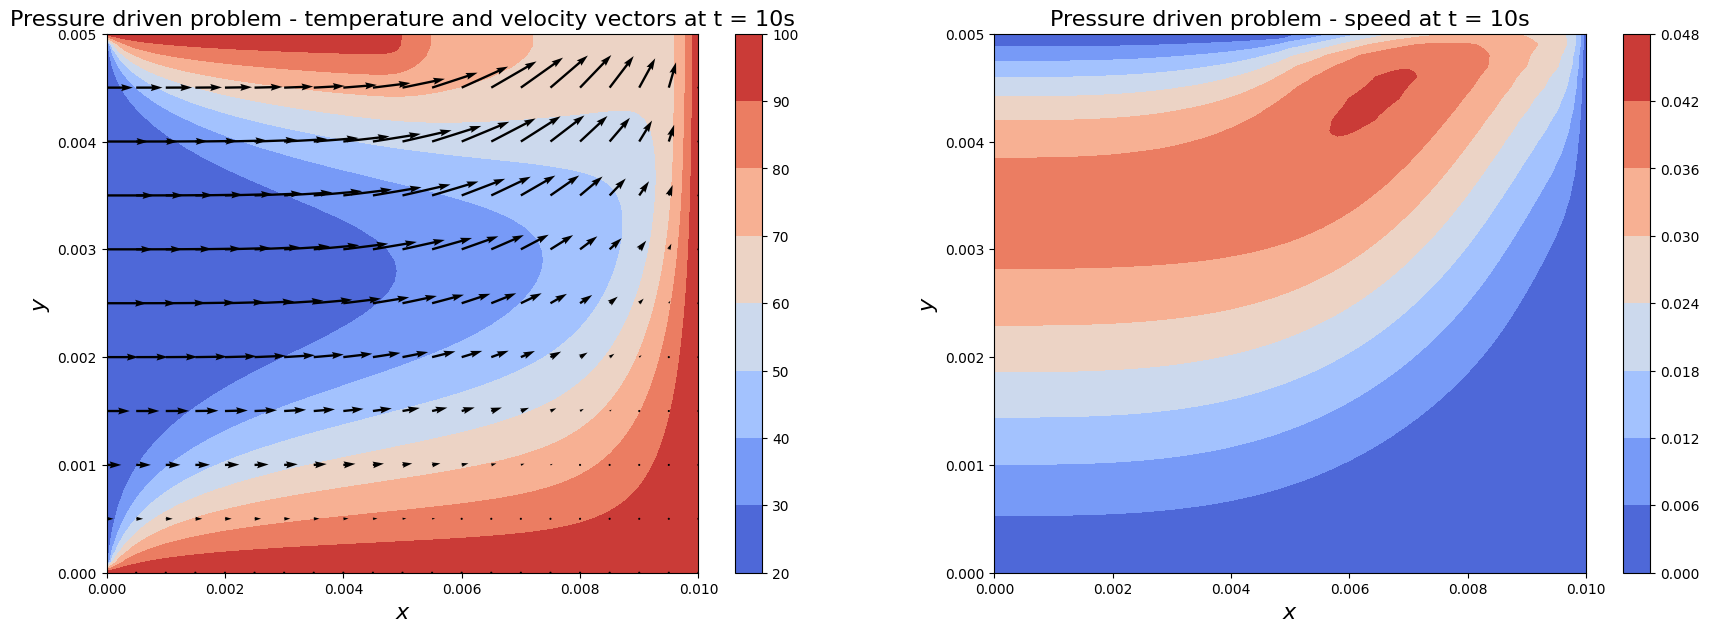

In [174]:
# set up figure
fig = plt.figure(figsize=(21, 7))
ax1 = fig.add_subplot(121)
cont = ax1.contourf(X,Y,T, cmap=cm.coolwarm)
fig.colorbar(cont)
# don't plot at every gird point - every 5th
ax1.quiver(X[::5,::5],Y[::5,::5],u[::5,::5],v[::5,::5])
ax1.set_xlim(-0.0000001, Lx + 0.0000001)
ax1.set_ylim(-0.0000001, Ly + 0.0000001)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Pressure driven problem - temperature and velocity vectors at t = 10s', fontsize=16)

ax1 = fig.add_subplot(122)
cont = ax1.contourf(X,Y,np.sqrt(u*u+v*v), cmap=cm.coolwarm)
fig.colorbar(cont)
ax1.set_xlim(-0.0000001, Lx + 0.0000001)
ax1.set_ylim(-0.0000001, Ly + 0.0000001)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Pressure driven problem - speed at t = 10s', fontsize=16);

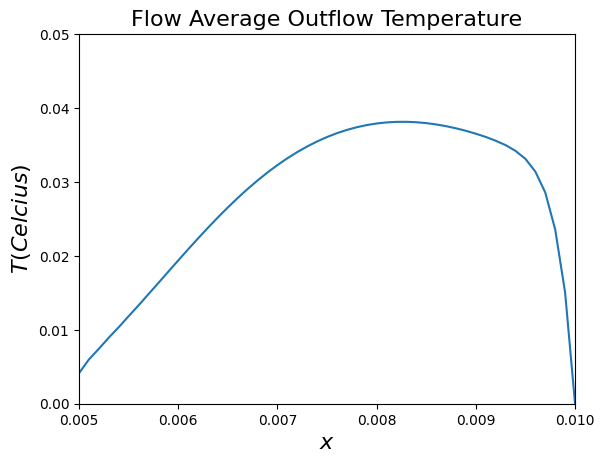

In [175]:
flow_average_outflow_T = np.average(T) * v[imax//2:, -1] * np.average(v[imax//2:, -1])
flow_average_outflow_T

plt.plot(np.arange(0.005, 0.0101, dx), flow_average_outflow_T)
plt.title('Flow Average Outflow Temperature', fontsize=16);
plt.xlim(0.005, 0.01)
plt.ylim(-0.0000001, 0.05)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$T (Celcius)$', fontsize=16);

# Part D

Dimensionless quantities that we could derive for this problem are the following:

* Reynolds number - shows us the ratio between inertial (velocity) and viscous forces for the pressure driven flow 
* Peclet number - advection vs conduction for temperature

Varying the variables that affect them we can get different solutions

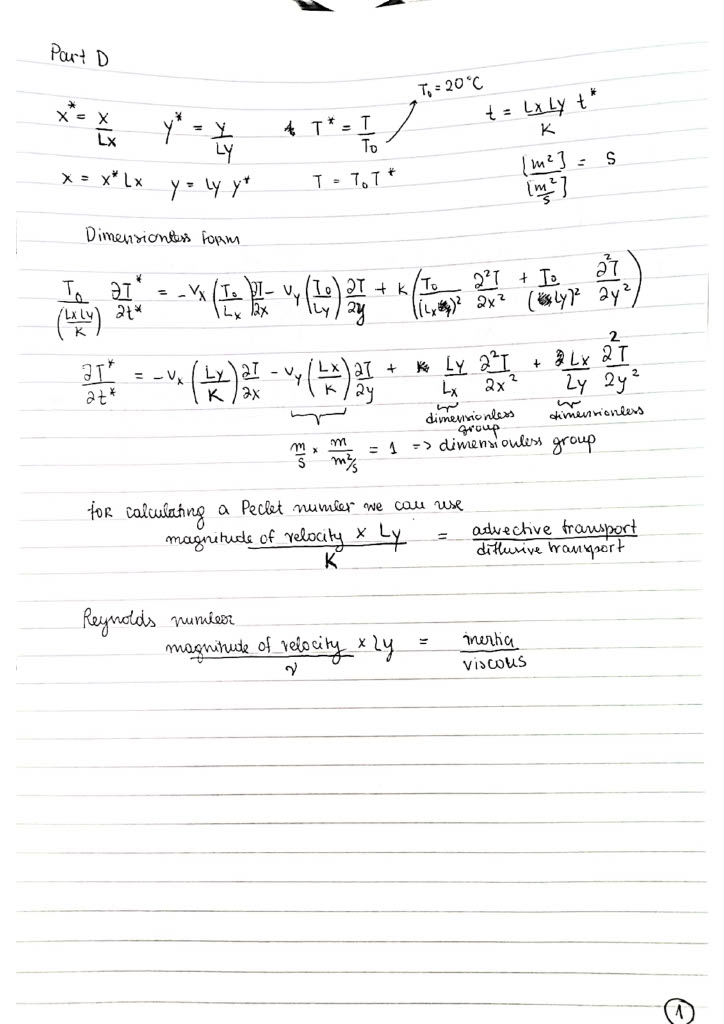

For the above base case Reynolds and Peclet number can be calculated based on the output

In [176]:
Re = np.average(np.sqrt(u**2+v**2))*Ly/nu
Re

95.680

In [178]:
Pe = np.average(np.sqrt(u**2+v**2))*Ly/k
Pe

19.136

We can expect that an increase in the kinematic viscousity will increase the effect of diffusive fluid transport. We can expect at the outlet the diffusion of the fluid from the boundary to preveil over the advection from the inlet which is at lower temperature. This means the outlet will be at higher temperature than at the base case.

Changing $\mu$ from 0.001 to 0.01

In [195]:
# physical parameters
rho = 1000
mu = 0.01
nu = mu/ rho
k = 5e-6

# define spatial mesh
# Size of rectangular domain
Lx = .01
Ly = Lx/2

P_max = 0.5

# Number of grid points in each direction, including boundary nodes
Nx = 101
Ny = 51

# hence the mesh spacing
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)

# read the docs to see the ordering that mgrid gives us
X, Y = np.mgrid[0:Nx:1, 0:Ny:1]
X = dx*X
Y = dy*Y
# the following is an alternative to the three lines above
#X, Y = np.mgrid[0: Lx + 1e-10: dx, 0: Ly + 1e-10: dy]
# but without the need to add a "small" increement to ensure
# the Lx and Ly end points are included

# initialise independent variables
u = np.zeros_like(X)
v = np.zeros_like(X)
p = np.zeros_like(X)

# Apply Dirichlet BCs to u and v - the code below doesn't touch 
# these so we can do this once outside the time loop
u[:, -1] = 0
u[:, 0] = 0
u[0, :] = 0
u[-1, :] = 0
v[:, -1] = 0
v[:, 0] = 0
v[0, :] = 0
v[-1, :] = 0
imax = len(p)
jmax = np.size(p)//imax

# left boundary
p[0, :] = P_max
p[imax//2:, -1] = 0.0

#set a Courant number and use dynamic time step
courant = 0.005
dt_min = 1.e-3

t_end = 10.

T = np.zeros_like(X)

# Dirichlet BCs
T[0, :] = 20 # left
T[-1,:] = 100 # right 
T[:, 0] = 100 # bottom
T[:imax//2, -1] = 100 # top

import time
start = time.time()
u, v, p, T = solve_NS_with_T(T, k, u, v, p, rho, nu, courant, dt_min, t_end, dx, dy, rtol=1.e-6, logs = True, outint = 10000)
end = time.time()
print('Time taken by calculation = ', end - start)


Time = 0.49849281
pressure solve iterations =    1
norm(u) = 0.62699439, norm(v) = 0.30456866
Courant number: 0.00500017
norm(T) = 4642.35691280
dt = 0.00003400

Time = 0.82209020
pressure solve iterations =    1
norm(u) = 0.67715665, norm(v) = 0.32771568
Courant number: 0.00500003
norm(T) = 4919.92915575
dt = 0.00003147

Time = 1.13406205
pressure solve iterations =    1
norm(u) = 0.68666184, norm(v) = 0.33208688
Courant number: 0.00500001
norm(T) = 4907.95737946
dt = 0.00003104

Time = 1.44388457
pressure solve iterations =    1
norm(u) = 0.68856926, norm(v) = 0.33296352
Courant number: 0.00500000
norm(T) = 4896.83983085
dt = 0.00003095

Time = 1.75327781
pressure solve iterations =    1
norm(u) = 0.68895614, norm(v) = 0.33314130
Courant number: 0.00500000
norm(T) = 4894.09257044
dt = 0.00003093

Time = 2.06258407
pressure solve iterations =    1
norm(u) = 0.68903477, norm(v) = 0.33317744
Courant number: 0.00500000
norm(T) = 4893.51458691
dt = 0.00003093

Time = 2.37187264
pressure 

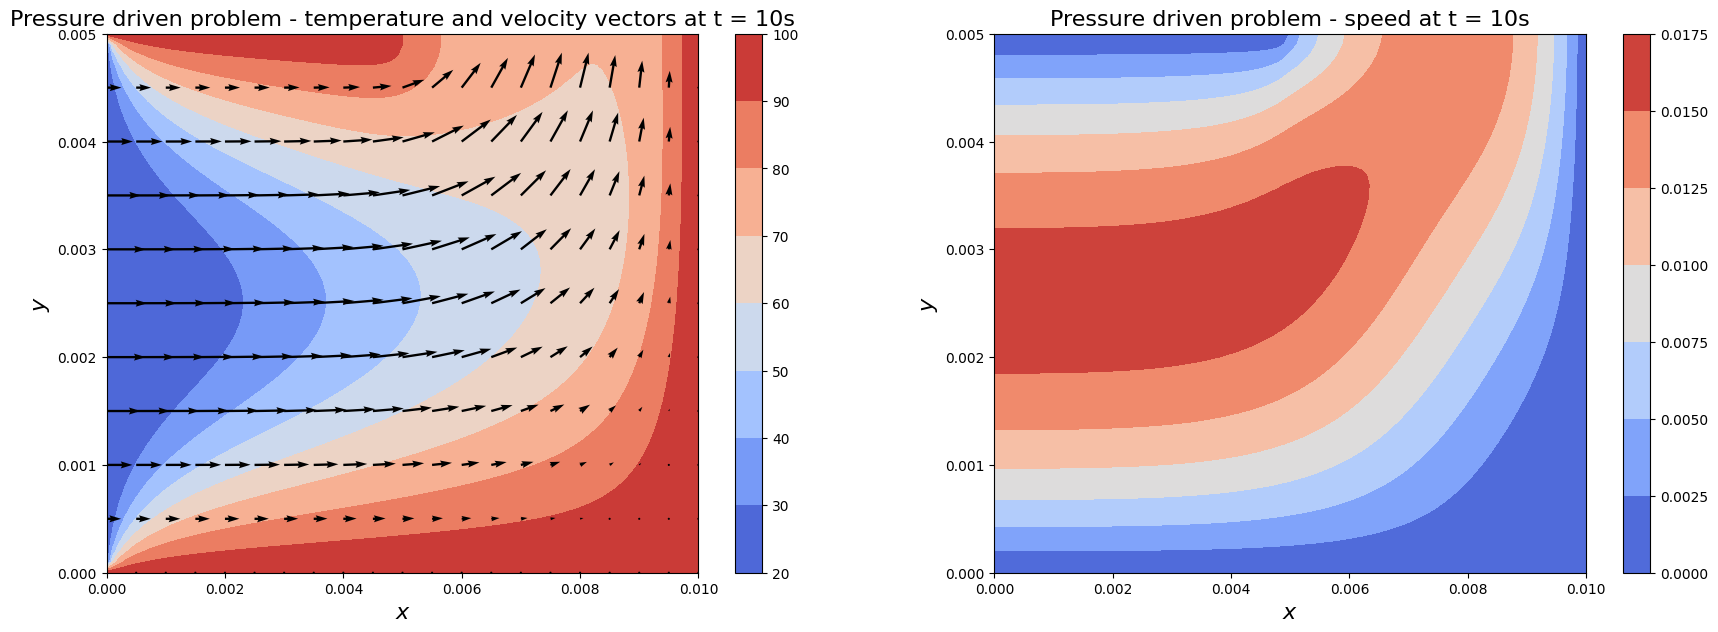

In [197]:
# set up figure
fig = plt.figure(figsize=(21, 7))
ax1 = fig.add_subplot(121)
cont = ax1.contourf(X,Y,T, cmap=cm.coolwarm)
fig.colorbar(cont)
# don't plot at every gird point - every 5th
ax1.quiver(X[::5,::5],Y[::5,::5],u[::5,::5],v[::5,::5])
ax1.set_xlim(-0.0000001, Lx + 0.0000001)
ax1.set_ylim(-0.0000001, Ly + 0.0000001)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Pressure driven problem - temperature and velocity vectors at t = 10s', fontsize=16)

ax1 = fig.add_subplot(122)
cont = ax1.contourf(X,Y,np.sqrt(u*u+v*v), cmap=cm.coolwarm)
fig.colorbar(cont)
ax1.set_xlim(-0.0000001, Lx + 0.0000001)
ax1.set_ylim(-0.0000001, Ly + 0.0000001)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Pressure driven problem - speed at t = 10s', fontsize=16);

In [ ]:
Re = np.average(np.sqrt(u**2+v**2))*Ly/nu
Re

In [ ]:
Pe = np.average(np.sqrt(u**2+v**2))*Ly/k
Pe

As expected increasing the viscosity of the fluid lead to more diffusion dominated profile. The velocity magnitude is almost 4 times lower. Because the fluid is moving through the volume slower the lower temperature at the inlet is advected way slower than the temperature from the boundary is diffused. This leads to the temperature at the outlet to increase by about 10 degrees compared to the base case. 

Interestingly this case, the solution reached steady state for the fluid flow way faster, at around 3.6s instead of over 8s for the base case

Similarly, we can expect increasing thermal diffusivity to produce similar effect, since then the temperature diffused from the boundary will be stronger than the advected heat from the inlet

In [239]:
mu = 0.001
nu = mu/rho
k = (5e-6)*2

# define spatial mesh
# Size of rectangular domain
Lx = .01
Ly = Lx/2

P_max = 0.5

# Number of grid points in each direction, including boundary nodes
Nx = 101
Ny = 51

# hence the mesh spacing
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)

# read the docs to see the ordering that mgrid gives us
X, Y = np.mgrid[0:Nx:1, 0:Ny:1]
X = dx*X
Y = dy*Y
# the following is an alternative to the three lines above
#X, Y = np.mgrid[0: Lx + 1e-10: dx, 0: Ly + 1e-10: dy]
# but without the need to add a "small" increement to ensure
# the Lx and Ly end points are included

# initialise independent variables
u = np.zeros_like(X)
v = np.zeros_like(X)
p = np.zeros_like(X)

# Apply Dirichlet BCs to u and v - the code below doesn't touch 
# these so we can do this once outside the time loop
u[:, -1] = 0
u[:, 0] = 0
u[0, :] = 0
u[-1, :] = 0
v[:, -1] = 0
v[:, 0] = 0
v[0, :] = 0
v[-1, :] = 0
imax = len(p)
jmax = np.size(p)//imax

# left boundary
p[0, :] = P_max
p[imax//2:, -1] = 0.0

#set a Courant number and use dynamic time step
courant = 0.05
dt_min = 1.e-3

t_end = 10.

T = np.zeros_like(X)

# Dirichlet BCs
T[0, :] = 20 # left
T[-1,:] = 100 # right 
T[:, 0] = 100 # bottom
T[:imax//2, -1] = 100 # top

import time
start = time.time()
u, v, p, T = solve_NS_with_T(T, k, u, v, p, rho, nu, courant, dt_min, t_end, dx, dy, rtol=1.e-6, logs = True, outint = 10000)
end = time.time()
print('Time taken by calculation = ', end - start)


Time = 1.00180000
pressure solve iterations =    1
norm(u) = 1.60239188, norm(v) = 0.66129482
Courant number: 0.04003468
norm(T) = 4839.83776172
dt = 0.00010000

Time = 2.00180000
pressure solve iterations =    1
norm(u) = 1.62005226, norm(v) = 0.62396485
Courant number: 0.04237223
norm(T) = 4879.39186852
dt = 0.00010000

Time = 3.00180000
pressure solve iterations =    1
norm(u) = 1.61178592, norm(v) = 0.61632464
Courant number: 0.04236654
norm(T) = 4892.13918663
dt = 0.00010000

Time = 4.00180000
pressure solve iterations =    1
norm(u) = 1.61073318, norm(v) = 0.61584011
Courant number: 0.04234772
norm(T) = 4893.01951479
dt = 0.00010000

Time = 5.00180000
pressure solve iterations =    1
norm(u) = 1.61068813, norm(v) = 0.61585454
Courant number: 0.04234562
norm(T) = 4893.00133165
dt = 0.00010000

Time = 6.00180000
pressure solve iterations =    1
norm(u) = 1.61069264, norm(v) = 0.61586060
Courant number: 0.04234556
norm(T) = 4892.99121835
dt = 0.00010000

Time = 7.00180000
pressure 

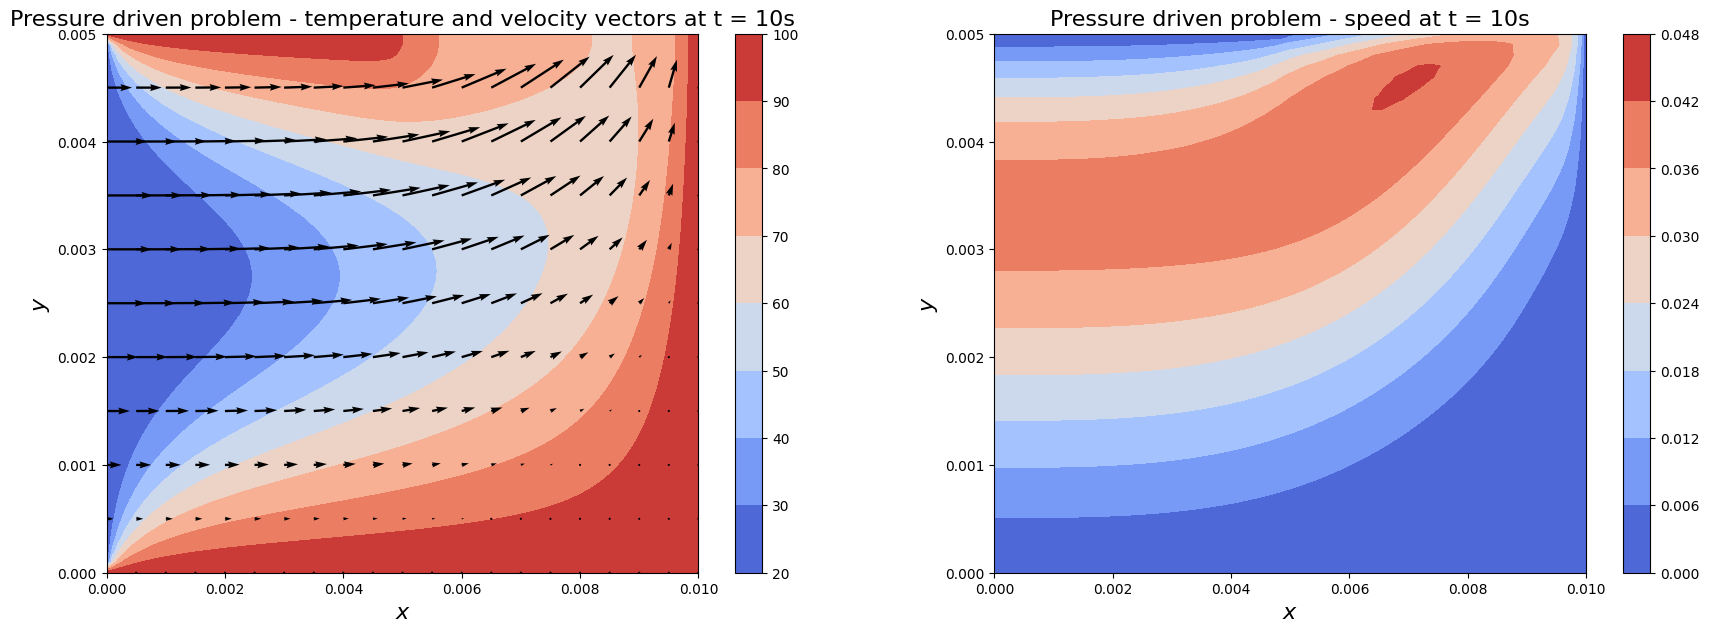

In [240]:
# set up figure
fig = plt.figure(figsize=(21, 7))
ax1 = fig.add_subplot(121)
cont = ax1.contourf(X,Y,T, cmap=cm.coolwarm)
fig.colorbar(cont)
# don't plot at every gird point - every 5th
ax1.quiver(X[::5,::5],Y[::5,::5],u[::5,::5],v[::5,::5])
ax1.set_xlim(-0.0000001, Lx + 0.0000001)
ax1.set_ylim(-0.0000001, Ly + 0.0000001)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Pressure driven problem - temperature and velocity vectors at t = 10s', fontsize=16)

ax1 = fig.add_subplot(122)
cont = ax1.contourf(X,Y,np.sqrt(u*u+v*v), cmap=cm.coolwarm)
fig.colorbar(cont)
ax1.set_xlim(-0.0000001, Lx + 0.0000001)
ax1.set_ylim(-0.0000001, Ly + 0.0000001)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Pressure driven problem - speed at t = 10s', fontsize=16);

In [241]:
Re = np.average(np.sqrt(u**2+v**2))*Ly/nu
Pe = np.average(np.sqrt(u**2+v**2))*Ly/k
print('Solution for increased thermal diffusivity')
print('Estimated Re and Pe based on numerical solution, Re = {0:.8f}, Pe = {1:.8f}'.format(Re, Pe))

Solution for increased thermal diffusivity
Estimated Re and Pe based on numerical solution, Re = 97.40559035, Pe = 9.74055904


As expected temperature at the outlet is closer to the temperature at the the boundary. Pe number is lower indicating that viscous effects are stronger for the heat transport. The Pe number is lower than in the previous case but diffusivity has not affected fluid transport as seen in the calculated Re number

In turn to increase the effect of advective transport we can increase the characteristic length or the pressure drop through increasing P_max. This will affect both the advection of the fluid and the heat. We could also increase the effect of advective fluid transport by dicreasing the viscous effect characterised by the kinematic viscousity $\mu$

Increasing the pressure drop:

note: also increased courant number since the simulation was too slow otherwise

In [207]:
# physical parameters
rho = 1000
mu = 0.001
nu = mu/ rho
k = 5e-6

# define spatial mesh
# Size of rectangular domain
Lx = .01
Ly = Lx/2

P_max = 5.

# Number of grid points in each direction, including boundary nodes
Nx = 101
Ny = 51

# hence the mesh spacing
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)

# read the docs to see the ordering that mgrid gives us
X, Y = np.mgrid[0:Nx:1, 0:Ny:1]
X = dx*X
Y = dy*Y
# the following is an alternative to the three lines above
#X, Y = np.mgrid[0: Lx + 1e-10: dx, 0: Ly + 1e-10: dy]
# but without the need to add a "small" increement to ensure
# the Lx and Ly end points are included

# initialise independent variables
u = np.zeros_like(X)
v = np.zeros_like(X)
p = np.zeros_like(X)

# Apply Dirichlet BCs to u and v - the code below doesn't touch 
# these so we can do this once outside the time loop
u[:, -1] = 0
u[:, 0] = 0
u[0, :] = 0
u[-1, :] = 0
v[:, -1] = 0
v[:, 0] = 0
v[0, :] = 0
v[-1, :] = 0
imax = len(p)
jmax = np.size(p)//imax

# left boundary
p[0, :] = P_max
p[imax//2:, -1] = 0.0

#set a Courant number and use dynamic time step
courant = 0.05
dt_min = 1.e-3

t_end = 10.

T = np.zeros_like(X)

# Dirichlet BCs
T[0, :] = 20 # left
T[-1,:] = 100 # right 
T[:, 0] = 100 # bottom
T[:imax//2, -1] = 100 # top

import time
start = time.time()
u, v, p, T = solve_NS_with_T(T, k, u, v, p, rho, nu, courant, dt_min, t_end, dx, dy, rtol=1.e-6, logs = True, outint = 10000)
end = time.time()
print('Time taken by calculation = ', end - start)


Time = 0.46469415
pressure solve iterations =    1
norm(u) = 5.39795950, norm(v) = 1.96131634
Courant number: 0.05000129
norm(T) = 3683.19811472
dt = 0.00003441

Time = 0.79232242
pressure solve iterations =    1
norm(u) = 5.59982672, norm(v) = 1.78150175
Courant number: 0.05000056
norm(T) = 3855.97065944
dt = 0.00003155

Time = 1.10097443
pressure solve iterations =    1
norm(u) = 5.72217123, norm(v) = 1.72137848
Courant number: 0.05000026
norm(T) = 3958.34711240
dt = 0.00003034

Time = 1.40129115
pressure solve iterations =    1
norm(u) = 5.78063540, norm(v) = 1.69678811
Courant number: 0.05000012
norm(T) = 4013.09426842
dt = 0.00002980

Time = 1.69790053
pressure solve iterations =    1
norm(u) = 5.80663727, norm(v) = 1.68600688
Courant number: 0.05000005
norm(T) = 4039.46503288
dt = 0.00002956

Time = 1.99288310
pressure solve iterations =    1
norm(u) = 5.81764268, norm(v) = 1.68120057
Courant number: 0.05000002
norm(T) = 4051.22354929
dt = 0.00002945

Time = 2.28716257
pressure 

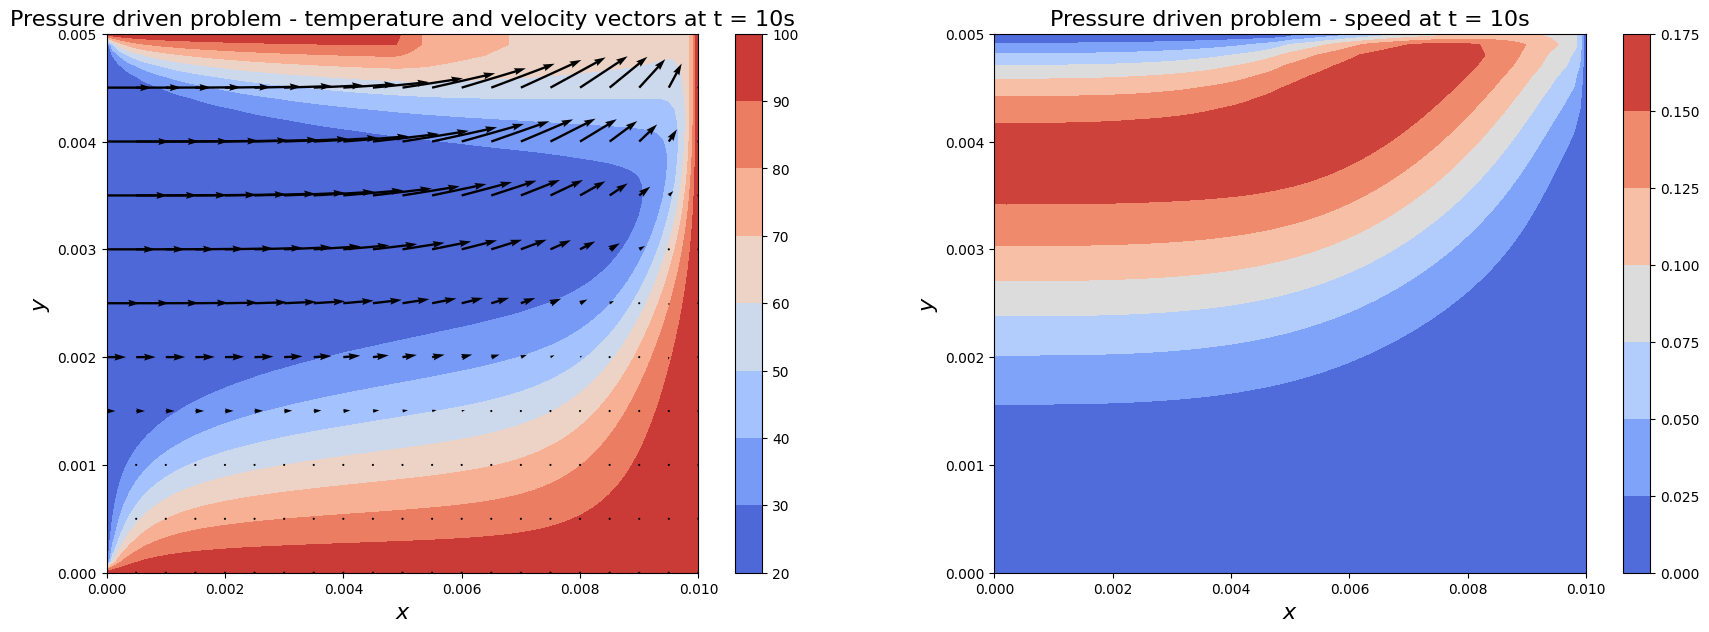

In [208]:
# set up figure
fig = plt.figure(figsize=(21, 7))
ax1 = fig.add_subplot(121)
cont = ax1.contourf(X,Y,T, cmap=cm.coolwarm)
fig.colorbar(cont)
# don't plot at every gird point - every 5th
ax1.quiver(X[::5,::5],Y[::5,::5],u[::5,::5],v[::5,::5])
ax1.set_xlim(-0.0000001, Lx + 0.0000001)
ax1.set_ylim(-0.0000001, Ly + 0.0000001)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Pressure driven problem - temperature and velocity vectors at t = 10s', fontsize=16)

ax1 = fig.add_subplot(122)
cont = ax1.contourf(X,Y,np.sqrt(u*u+v*v), cmap=cm.coolwarm)
fig.colorbar(cont)
ax1.set_xlim(-0.0000001, Lx + 0.0000001)
ax1.set_ylim(-0.0000001, Ly + 0.0000001)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Pressure driven problem - speed at t = 10s', fontsize=16);

In [209]:
Re = np.average(np.sqrt(u**2+v**2))*Ly/nu
Pe = np.average(np.sqrt(u**2+v**2))*Ly/k
print('Solution for increased pressure difference')
print('Estimated Re and Pe based on numerical solution, Re = {0:.8f}, Pe = {1:.8f}'.format(Re, Pe))

Solution for increased pressure difference
Estimated Re and Pe based on numerical solution, Re = 300.86306614, Pe = 60.17261323


Once again reaches steady state faster than base case around 7s. We can see that advection now drives the low temperature front further into the volume, decreasing overall temperature. Velocity magnitudes have also increased between the inlet and outlet

Pressure difference affected both Reynolds and Peclet numbers as expected

Not present in the dimensionless analysis another interesting parameter to change would be the initial temperature at the boundaries. According to the dimensionless groups for this problem it should have no affect our profile other than reversing the gradients

Let's have the boundaries below the temperature of the inlet

In [210]:
# physical parameters
rho = 1000
mu = 0.001
nu = mu/ rho
k = 5e-6

# define spatial mesh
# Size of rectangular domain
Lx = .01
Ly = Lx/2

P_max = .5

# Number of grid points in each direction, including boundary nodes
Nx = 101
Ny = 51

# hence the mesh spacing
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)

# read the docs to see the ordering that mgrid gives us
X, Y = np.mgrid[0:Nx:1, 0:Ny:1]
X = dx*X
Y = dy*Y
# the following is an alternative to the three lines above
#X, Y = np.mgrid[0: Lx + 1e-10: dx, 0: Ly + 1e-10: dy]
# but without the need to add a "small" increement to ensure
# the Lx and Ly end points are included

# initialise independent variables
u = np.zeros_like(X)
v = np.zeros_like(X)
p = np.zeros_like(X)

# Apply Dirichlet BCs to u and v - the code below doesn't touch 
# these so we can do this once outside the time loop
u[:, -1] = 0
u[:, 0] = 0
u[0, :] = 0
u[-1, :] = 0
v[:, -1] = 0
v[:, 0] = 0
v[0, :] = 0
v[-1, :] = 0
imax = len(p)
jmax = np.size(p)//imax

# left boundary
p[0, :] = P_max
p[imax//2:, -1] = 0.0

#set a Courant number and use dynamic time step
courant = 0.05
dt_min = 1.e-3

t_end = 10.

T = np.zeros_like(X)

# Dirichlet BCs
T[0, :] = 20 # left
T[-1,:] = 10 # right 
T[:, 0] = 10 # bottom
T[:imax//2, -1] = 10 # top

import time
start = time.time()
u, v, p, T = solve_NS_with_T(T, k, u, v, p, rho, nu, courant, dt_min, t_end, dx, dy, rtol=1.e-6, logs = True, outint = 10000)
end = time.time()
print('Time taken by calculation = ', end - start)


Time = 1.55103404
pressure solve iterations =    1
norm(u) = 1.62765770, norm(v) = 0.63744036
Courant number: 0.05000033
norm(T) = 416983022658.19879150
dt = 0.00011872

Time = 2.73203455
pressure solve iterations =    1
norm(u) = 1.61343131, norm(v) = 0.61732036
Courant number: 0.04999999
norm(T) = 510553.58479186
dt = 0.00011802

Time = 3.91271782
pressure solve iterations =    1
norm(u) = 1.61137754, norm(v) = 0.61617156
Courant number: 0.05000000
norm(T) = 1136.35842436
dt = 0.00011810

Time = 5.09374710
pressure solve iterations =    1
norm(u) = 1.61131399, norm(v) = 0.61618444
Courant number: 0.05000000
norm(T) = 1136.64704642
dt = 0.00011810

Time = 6.27479755
pressure solve iterations =    1
norm(u) = 1.61131842, norm(v) = 0.61618965
Courant number: 0.05000000
norm(T) = 1136.64829790
dt = 0.00011811

Time = 7.45584785
pressure solve iterations =    1
norm(u) = 1.61131892, norm(v) = 0.61618989
Courant number: 0.05000000
norm(T) = 1136.64834405
dt = 0.00011811

Time = 8.63689806

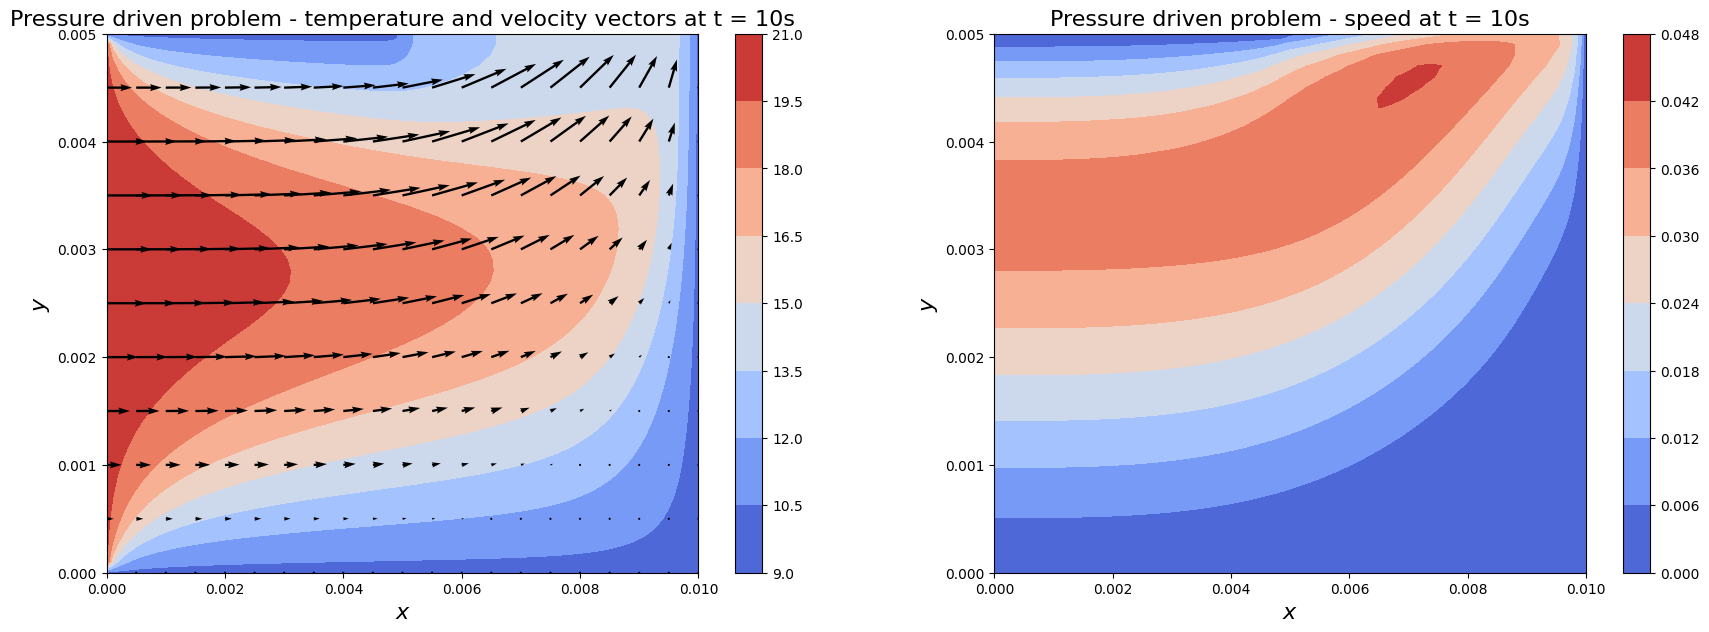

In [215]:
# set up figure
fig = plt.figure(figsize=(21, 7))
ax1 = fig.add_subplot(121)
cont = ax1.contourf(X,Y,T, cmap= cm.coolwarm)
fig.colorbar(cont)
# don't plot at every gird point - every 5th
ax1.quiver(X[::5,::5],Y[::5,::5],u[::5,::5],v[::5,::5])
ax1.set_xlim(-0.0000001, Lx + 0.0000001)
ax1.set_ylim(-0.0000001, Ly + 0.0000001)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Pressure driven problem - temperature and velocity vectors at t = 10s', fontsize=16)

ax1 = fig.add_subplot(122)
cont = ax1.contourf(X,Y,np.sqrt(u*u+v*v), cmap=cm.coolwarm)
fig.colorbar(cont)
ax1.set_xlim(-0.0000001, Lx + 0.0000001)
ax1.set_ylim(-0.0000001, Ly + 0.0000001)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Pressure driven problem - speed at t = 10s', fontsize=16);

In [212]:
Re = np.average(np.sqrt(u**2+v**2))*Ly/nu
Pe = np.average(np.sqrt(u**2+v**2))*Ly/k
print('Solution for changed boundary conditions')
print('Estimated Re and Pe based on numerical solution, Re = {0:.8f}, Pe = {1:.8f}'.format(Re, Pe))

Solution for increased thermal diffusivity
Estimated Re and Pe based on numerical solution, Re = 97.47449475, Pe = 19.49489895


As expected this is the reverse magnitude profile of our base solution

Additionally, what if we have the two dimensions in the system very different from each other. Let's set Lx to 1

In [250]:
# physical parameters
rho = 1000
mu = 0.001
nu = mu/ rho
k = 5e-6

# define spatial mesh
# Size of rectangular domain
Lx = 1.
Ly = Lx/2

P_max = .5

# Number of grid points in each direction, including boundary nodes
Nx = 101
Ny = 51

# hence the mesh spacing
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)

# read the docs to see the ordering that mgrid gives us
X, Y = np.mgrid[0:Nx:1, 0:Ny:1]
X = dx*X
Y = dy*Y
# the following is an alternative to the three lines above
#X, Y = np.mgrid[0: Lx + 1e-10: dx, 0: Ly + 1e-10: dy]
# but without the need to add a "small" increement to ensure
# the Lx and Ly end points are included

# initialise independent variables
u = np.zeros_like(X)
v = np.zeros_like(X)
p = np.zeros_like(X)

# Apply Dirichlet BCs to u and v - the code below doesn't touch 
# these so we can do this once outside the time loop
u[:, -1] = 0
u[:, 0] = 0
u[0, :] = 0
u[-1, :] = 0
v[:, -1] = 0
v[:, 0] = 0
v[0, :] = 0
v[-1, :] = 0
imax = len(p)
jmax = np.size(p)//imax

# left boundary
p[0, :] = P_max
p[imax//2:, -1] = 0.0

#set a Courant number and use dynamic time step
courant = 0.005
dt_min = 1.e-3

t_end = 100.

T = np.zeros_like(X)

# Dirichlet BCs
T[0, :] = 20 # left
T[-1,:] = 100 # right 
T[:, 0] = 100 # bottom
T[:imax//2, -1] = 100 # top

import time
start = time.time()
u, v, p, T = solve_NS_with_T(T, k, u, v, p, rho, nu, courant, dt_min, t_end, dx, dy, rtol=1.e-6, logs = True, outint = 10000)
end = time.time()
print('Time taken by calculation = ', end - start)


Time = 10.00000000
pressure solve iterations =    2
norm(u) = 0.34612939, norm(v) = 0.16461355
Courant number: 0.00144700
norm(T) = 1507.71472769
dt = 0.00100000

Time = 20.00000000
pressure solve iterations =    2
norm(u) = 0.65426330, norm(v) = 0.30302269
Courant number: 0.00204196
norm(T) = 1633.67102915
dt = 0.00100000

Time = 30.00000000
pressure solve iterations =    2
norm(u) = 0.91654987, norm(v) = 0.42267976
Courant number: 0.00251360
norm(T) = 1776.53229158
dt = 0.00100000

Time = 40.00000000
pressure solve iterations =    1
norm(u) = 1.11961816, norm(v) = 0.51492950
Courant number: 0.00291127
norm(T) = 1927.77211063
dt = 0.00100000

Time = 50.00000000
pressure solve iterations =    1
norm(u) = 1.26483299, norm(v) = 0.57704897
Courant number: 0.00323555
norm(T) = 2073.89103836
dt = 0.00100000

Time = 60.00000000
pressure solve iterations =    1
norm(u) = 1.36265994, norm(v) = 0.61327729
Courant number: 0.00349228
norm(T) = 2167.71506766
dt = 0.00100000

Time = 70.00000000
pr

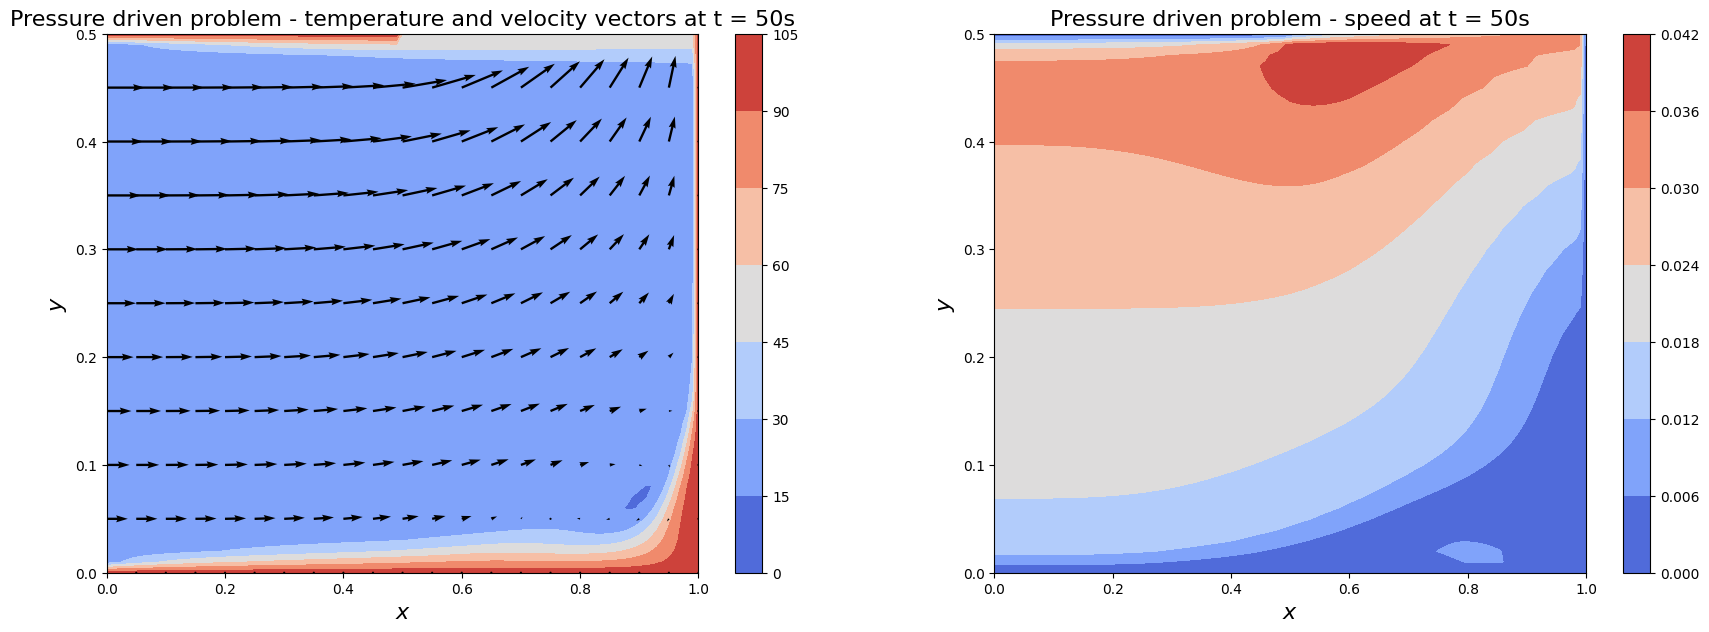

In [251]:
# set up figure
fig = plt.figure(figsize=(21, 7))
ax1 = fig.add_subplot(121)
cont = ax1.contourf(X,Y,T, cmap= cm.coolwarm)
fig.colorbar(cont)
# don't plot at every gird point - every 5th
ax1.quiver(X[::5,::5],Y[::5,::5],u[::5,::5],v[::5,::5])
ax1.set_xlim(-0.0000001, Lx + 0.0000001)
ax1.set_ylim(-0.0000001, Ly + 0.0000001)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Pressure driven problem - temperature and velocity vectors at t = 50s', fontsize=16)

ax1 = fig.add_subplot(122)
cont = ax1.contourf(X,Y,np.sqrt(u*u+v*v), cmap=cm.coolwarm)
fig.colorbar(cont)
ax1.set_xlim(-0.0000001, Lx + 0.0000001)
ax1.set_ylim(-0.0000001, Ly + 0.0000001)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Pressure driven problem - speed at t = 50s', fontsize=16);

In [ ]:
Re = np.average(np.sqrt(u**2+v**2))*Ly/nu
Pe = np.average(np.sqrt(u**2+v**2))*Ly/k
print('Solution for increased Lx')
print('Estimated Re and Pe based on numerical solution, Re = {0:.8f}, Pe = {1:.8f}'.format(Re, Pe))

As we can see with the new value for Lx, the system doesn't reach steady state at the same time as our base case. As shown above profile looks very different, probably not only because of the change of dimension of the box, but also the bigger outlet - since the outlet is half of Lx